# Airbnb - Data Modelling and Evaluation (Vancouver)

Complete Modelling and evaluation parts of the CRISP-DM process. Answer the following two questions:

 - Possible to predict price based on features of airbnb & seasonal trend?
 - Which Airbnb features have the largest impact on price
 


## Imports

In [1]:
#Imports basic functions
import pandas as pd
import numpy as np
import re

#Imports functions for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import matplotlib.style as style

#Sklearn imports
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score, make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Import custom airbnb package
import AirBnb_pkg as airbnb

## Functions

In [2]:
def plot_histogram(data, column, binsize=50, y_label='', x_label='', color='blue'):
    """
    Function to plot standard histograms (Can be used for individual or side by side plots)
    """
    # Plots the Graph with title & axis
    ax = sns.distplot(data[column], kde=False, color=color, bins=binsize)
        
    # Sets up the title based on the plotting column and the market    
    ax.set_title(f"Vancouver - Listing Prices", fontsize=25)
    
    # Sets the y and x labels
    ax.set_ylabel(y_label, fontsize=24)
    ax.set_xlabel(x_label, fontsize=24)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
        
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    
    # Removes spines and changes layout to tight
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
def plot_line(data, ax, color, alpha=.7, ls='-', lw=5, label=None):
    """
    plots the standard line graph
    """
    ax.plot(data, color=color,
            alpha=alpha, ls=ls,
            linewidth=lw, label=label)
    
    #Set the x-labels and y limits
    x_ticks = pd.to_datetime(Vancouver_CPM.index)
    
    ax.set_xticklabels([pd.to_datetime(x).strftime('%B') for x in x_ticks],
                      rotation=45,
                      fontsize=15)
    
    ax.set_xticks(x_ticks)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
        
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15)
        
    #ax.set_ylim(40,100)
    #ax.tick_params(axis='y')
    
    #Plot the legend
    h1, l1 = ax.get_legend_handles_labels()
    ax.legend(loc=2, frameon=False)
    
    #Remove spines and change layout to tight
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()

## Basic Setup

Read data, create global variables

In [3]:
#Plotting settings
style.use('seaborn-poster')
style.use('seaborn-darkgrid')
plt.rcParams['font.family'] = 'sans serif'

In [4]:
#Read in .csv file
Vancouver_Cal = pd.read_csv('Data/calendar.csv.gz')
Vancouver_List = pd.read_csv('Data/listings.csv.gz')

In [5]:
#Create ML input using custom package
Vancouver_input = airbnb.ML_preprocessing(Vancouver_Cal, Vancouver_List)

Columns dropped: {'square_feet', 'monthly_price', 'weekly_price'}
Number of rows dropped: 0


## Data Modelling##

Try random forest algorithm:

 - Suited towards creating regression models with may features (280 in this dataset)
 - Quick to train
 - Useful for feature importance
 
Downsides:

 - Can overfit
 - May skew importance towards categorical variables
 

In [6]:
#Set X & Y variables
X = Vancouver_input.iloc[:,1:]
Y = Vancouver_input.iloc[:,0].values  #Calendar price

#Split data into training and test (20% held for testing)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [7]:
Vancouver_input.columns[0:]

Index(['Cal_price', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       ...
       'Wheelchair accessible', 'Wide clearance to shower',
       'Wide doorway to guest bathroom', 'Wide entrance',
       'Wide entrance for guests', 'Wide entryway', 'Wide hallways', 'Wifi',
       'Window guards', 'Wine cooler'],
      dtype='object', length=280)

In [8]:
#Use a gridsearch to search over parameters for the random forest estimator
rf = RandomForestRegressor(oob_score=True, bootstrap=True, random_state=14)

parameters = {
    'n_estimators' : [1,2,10,50,100,200],
    'min_samples_leaf' : [1,2,3],
    'min_samples_split' : [2,3,4]
}

#create gridsearch object
reg = GridSearchCV(rf, param_grid=parameters, n_jobs=-1, verbose=2, cv=5)

#train
reg.fit(X_train, y_train)

#predict on test data
y_pred = reg.best_estimator_.predict(X_test)

print("\nOptimised Model\n-----")
print(f'RMSE Train Score: {reg.best_estimator_.score(X_train, y_train)}')
print(f'RMSE Test Score: {reg.best_estimator_.score(X_test, y_test)}')


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 10.0min finished



Optimised Model
-----
RMSE Train Score: 0.8858960745456392
RMSE Test Score: 0.6266777089343866


Training score RSME is 85% accurate, pretty good, but the test score of 62% indicates overfitting of the model. This may be due to the 280 features all influencing the model.

MAE should be evaluated as RMSE may be over-penalizing due to outliers.

In [9]:
#Calculate accuracy based on MAE rather than RMSE

errors = abs(y_pred - y_test)

print('Average absolute error:', round(np.mean(errors), 2))

mae = np.mean(errors)

print('Mean absolute error:', round(np.mean(mae), 2))

mape= np.mean(100 * (errors / y_test))

print('Mean absolute percentage error:', round(np.mean(mape), 2))

accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%')

#save the model for baseline
mae_baseline = mae
mape_baseline = mape

Average absolute error: 48.52
Mean absolute error: 48.52
Mean absolute percentage error: 33.38
Accuracy: 66.62 %


Better but still skewed by outlier.

Remove outliers and re-create model.

In [10]:
def outlier_removal(df_in, col_name, outlier_pctile=5):
    q1 = df_in[col_name].quantile(outlier_pctile/100)
    q3 = df_in[col_name].quantile(1 - (outlier_pctile/100))
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [11]:
def print_metrics(y_pred, y_test, baseline_mae, baseline_mape):
    
    errors = abs(y_pred - y_test)
    mae = np.mean(errors)
    mape= np.mean(100 * (errors / y_test))
    accuracy = 100 - mape
    mape_improvement = baseline_mape - mape
    
    print('Mean absolute error:', round(np.mean(mae), 2))
    print('Mean absolute percentage error:', round(np.mean(mape), 2))
    print('Accuracy:', round(accuracy, 2), '%')
    print('MAPE Improvement:', round(mape_improvement, 2))
    print('MAPE Improvement:', round((mape_improvement/baseline_mape), 2), '%')

In [12]:
#Remove extreme outliers (5%)
Vancouver_ro = outlier_removal(Vancouver_input, 'Cal_price', outlier_pctile=5)

X = Vancouver_ro.iloc[:,1:]
Y = Vancouver_ro.iloc[:,0].values

#Split data into training and test (20% held for testing)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

#Setup random forest classifier
rf = RandomForestRegressor(oob_score=True, bootstrap=True, random_state=14)

parameters = {
    'n_estimators' : [1,2,10,50,100,200],
    'min_samples_leaf' : [1,2,3],
    'min_samples_split' : [2,3,4]
}

#create gridsearch object
reg = GridSearchCV(rf, param_grid=parameters, n_jobs=-1, verbose=2, cv=5)

#train
reg.fit(X_train, y_train)

#predict on test data
y_pred = reg.best_estimator_.predict(X_test)

print("\nOptimised Model\n-----")
print(f'RMSE Train Score: {reg.best_estimator_.score(X_train, y_train)}')
print(f'RMSE Test Score: {reg.best_estimator_.score(X_test, y_test)}')

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  9.4min finished



Optimised Model
-----
RMSE Train Score: 0.9163175840863637
RMSE Test Score: 0.6144911387846175


In [13]:
print_metrics(y_pred, y_test, mae_baseline, mape_baseline)

Mean absolute error: 48.55
Mean absolute percentage error: 30.07
Accuracy: 69.93 %
MAPE Improvement: 3.31
MAPE Improvement: 0.1 %


Removal of outliers improved accuracy of the model. Next step is to perform scaling to ensure that variables with larger numerical range dont have a larger influence on the data.

In [14]:
#Feature scaling of the input data
StdSclr = StandardScaler()
Vancouver_sc = pd.DataFrame(StdSclr.fit_transform(Vancouver_ro))

X = Vancouver_sc.iloc[:,1:]

#Note: do not used scaled price data
Y = Vancouver_ro.iloc[:,0].values

#Split data into training and test (20% held for testing)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

#Setup random forest classifier
rf = RandomForestRegressor(oob_score=True, bootstrap=True, random_state=14)

parameters = {
    'n_estimators' : [1,2,10,50,100,200],
    'min_samples_leaf' : [1,2,3],
    'min_samples_split' : [2,3,4]
}

#create gridsearch object
reg = GridSearchCV(rf, param_grid=parameters, n_jobs=-1, verbose=2, cv=5)

#train
reg.fit(X_train, y_train)

#predict on test data
y_pred = reg.best_estimator_.predict(X_test)

print("\nOptimised Model\n-----")
print(f'RMSE Train Score: {reg.best_estimator_.score(X_train, y_train)}')
print(f'RMSE Test Score: {reg.best_estimator_.score(X_test, y_test)}')

print_metrics(y_pred, y_test, mae_baseline, mape_baseline)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  9.2min finished



Optimised Model
-----
RMSE Train Score: 0.9153554197733033
RMSE Test Score: 0.6483364687722821
Mean absolute error: 47.07
Mean absolute percentage error: 31.48
Accuracy: 68.52 %
MAPE Improvement: 1.9
MAPE Improvement: 0.06 %


Feature scaling made little difference to model accuracy.

For further improvements we could drop individual features until a "best" model is found. This is computationally expensive. Let's rerun the model with the best parameters and refactor it into a module.

In [15]:
reg.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=True, random_state=14, verbose=0,
                      warm_start=False)

In [16]:
def RF_price_model(X_model_input, Y_model_input):
    """
    Creates the price regression Random Forests based on the desired input df
    (Expects dependent variable to be the first column)
    """
    # Set the X & Y variables
    X = X_model_input.iloc[:,1:]
    Y = Y_model_input.iloc[:,0].values

    # split into training & testing data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    
    # setup the random forests classifier
    rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=True, random_state=14, verbose=0,
                      warm_start=False)

    # train classifier
    rf.fit(X_train, y_train)

    # predict on test data
    y_pred = rf.predict(X_test)

    print("\nOptimised Model\n------")
    print(f'RMSE Train Score: {rf.score(X_train, y_train)}')
    print(f'RMSE Test Score: {rf.score(X_test,y_test)}')
    
    print_metrics(y_pred, y_test, baseline_mae=mae_baseline, baseline_mape=mape_baseline)
    
    return rf, X_train, y_train

In [17]:
best_model, X_train, y_train = RF_price_model(Vancouver_sc, Vancouver_ro)


Optimised Model
------
RMSE Train Score: 0.9155112445323399
RMSE Test Score: 0.6355557151671916
Mean absolute error: 48.79
Mean absolute percentage error: 33.38
Accuracy: 66.62 %
MAPE Improvement: -0.0
MAPE Improvement: -0.0 %


## Evaluation

Attempt to improve the "best" model further. Examine feature importance by removing features via a loop and comparing accuracy to the "best" model baseline.

In [90]:
#Create a list of the feature names
feat_labels = Vancouver_ro.columns[1:]

#print the name and gini importance of each feature
feat_importance = []
for feature in zip(feat_labels, best_model.feature_importances_):
    feat_importance.append(feature)
    
importances_df = pd.DataFrame(feat_importance, columns = ['feature', 'gini_index'])

importances_df

,feature,gini_index
0,accommodates,0.355559
1,bathrooms,0.120832
2,bedrooms,0.019976
3,beds,0.008017
4,number_of_reviews,0.029531
...,...,...
274,Wide entryway,0.000284
275,Wide hallways,0.000784
276,Wifi,0.000074
277,Window guards,0.000146


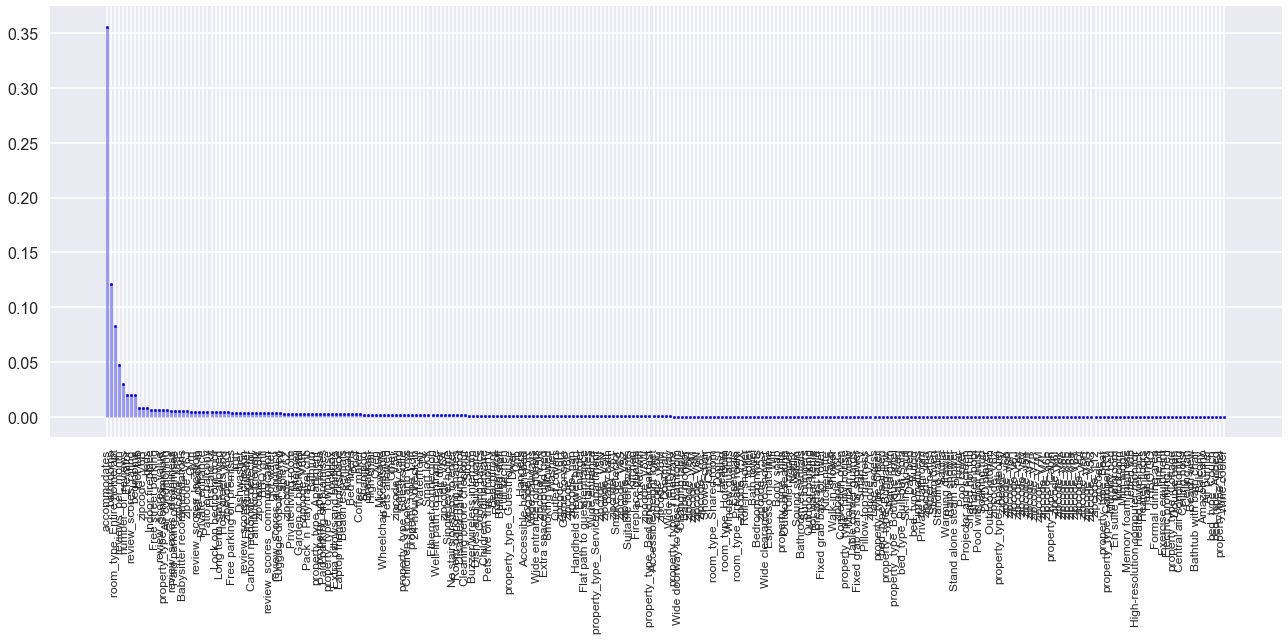

In [133]:
def plot_feature_importance(feat_importance):
    """
    This plot is designed to plot the feature performance in the model
    """
    # It's probably easier to represent this data graphically
    fig, ax = plt.subplots(figsize=(18,9))
    
    feat_imp = feat_importance.sort_values('gini_index', ascending=False)

    x=range(0,len(feat_imp))
    y=feat_imp['gini_index']
    
    ax.vlines(x=x, ymin=0, ymax=y, color='blue', alpha=0.4)
    ax.scatter(x, y, color='blue', s=6, alpha=1)
    
    plt.xticks(range(0,len(feat_imp)), list(feat_imp['feature']), rotation=90, fontsize=12)
                      
    plt.tight_layout()

plot_feature_importance(importances_df)

There is clearly too many features, many of which have no significance to price. Drop values with gini < 0.005

In [108]:
importances_df

,feature,gini_index
0,accommodates,0.355559
1,bathrooms,0.120832
2,bedrooms,0.019976
3,beds,0.008017
4,number_of_reviews,0.029531
...,...,...
274,Wide entryway,0.000284
275,Wide hallways,0.000784
276,Wifi,0.000074
277,Window guards,0.000146


In [126]:
#Remove columns with gini < 0.005
col_drop = importances_df.drop(importances_df[importances_df.gini_index > 0.002].index)
col_drop_list = col_drop['feature'].tolist()
Vancouver_drop = Vancouver_ro.drop(columns = col_drop_list)

StdSclr = StandardScaler()
Vancouver_sc_update = pd.DataFrame(StdSclr.fit_transform(Vancouver_drop))

new_rf, X_train, y_train = RF_price_model(Vancouver_sc_update, Vancouver_drop)


Optimised Model
------
RMSE Train Score: 0.9151385152808434
RMSE Test Score: 0.6326486202095103
Mean absolute error: 45.78
Mean absolute percentage error: 31.55
Accuracy: 68.45 %
MAPE Improvement: 1.83
MAPE Improvement: 0.05 %


In [127]:
#Create a list of the feature names
updated_feat_labels = Vancouver_drop.columns[1:]

#print the name and gini importance of each feature
updated_feat_importance = []
for feature in zip(feat_labels, new_rf.feature_importances_):
    updated_feat_importance.append(feature)
    
updated_importances_df = pd.DataFrame(updated_feat_importance, columns = ['feature', 'gini_index'])

updated_importances_df

,feature,gini_index
0,accommodates,0.359831
1,bathrooms,0.125442
2,bedrooms,0.021225
3,beds,0.015434
4,number_of_reviews,0.035243
...,...,...
62,zipcode_v5v,0.002546
63,zipcode_v5w,0.005871
64,zipcode_v6J,0.003962
65,zipcode_v6P,0.004472


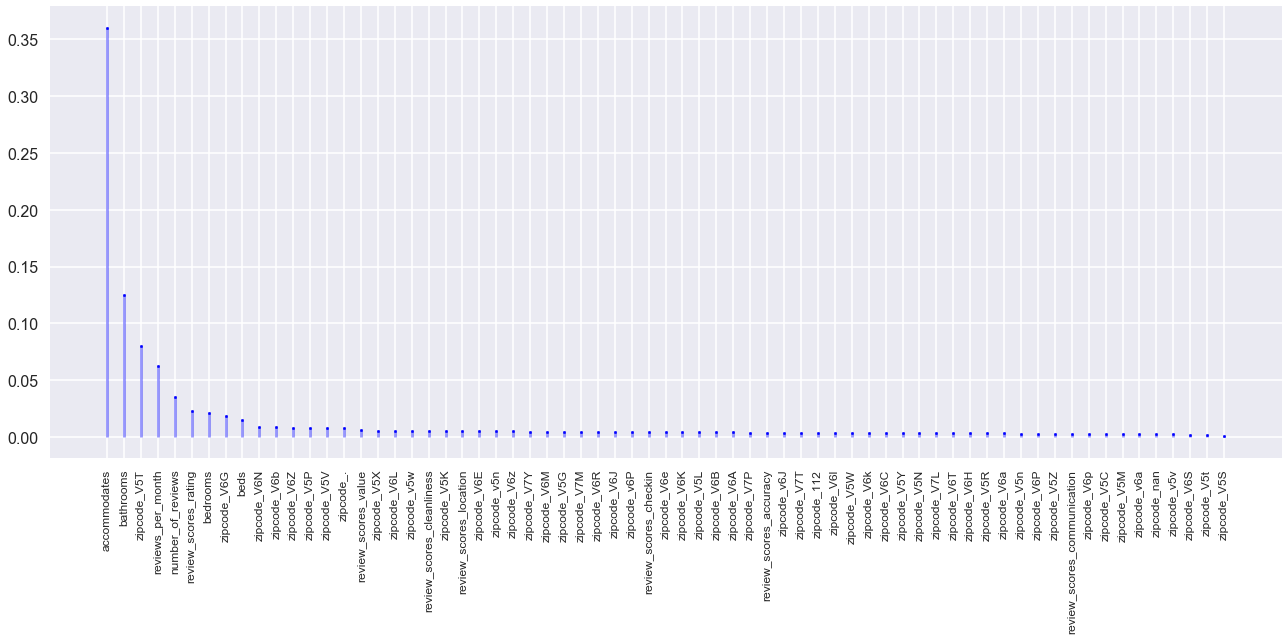

In [134]:
plot_feature_importance(updated_importances_df)

___Answer: Which Airbnb listing variables have the biggest impact on price?___

The results of the above feature importance show that the number of guests accomodated, number of bathrooms, and number of bedrooms rank are the most critical features. Certain postal codes appear to be highly influential. Reviews per month, number of review, and review score all are influential for existing users. This makes sense as the higher the number of guests that can be accomodated, there is an ability to charge a higher price.

It is worth noting that there are no features with gini > 0.002 which describe amenities. Almost all pricing effect is due to the number of guests, the postal code, and characteristics of the reviews.

Existing Airbnb users could influence their price by incenting users to leave reviews for every stay. New users could provide heavily discounted rates initially to increase the reviews/month and total reviews metrics. Choosing a neighbourhood to establish an new Airbnb appears to be critical.

In order to predict price, we must remove features related to reviews as these are not latent to the property.

In [158]:
col_drop = importances_df.drop(importances_df[importances_df.gini_index > 0.002].index)
col_drop_list = col_drop['feature'].tolist() + ['reviews_per_month','number_of_reviews','review_scores_rating',
                               'review_scores_value', 'review_scores_location',
                               'review_scores_cleanliness', 'review_scores_checkin',
                               'review_scores_accuracy', 'review_scores_communication']

Vancouver_drop = Vancouver_ro.drop(columns = col_drop_list)

StdSclr = StandardScaler()
Vancouver_sc_update = pd.DataFrame(StdSclr.fit_transform(Vancouver_drop))

Vancouver_sc_update

new_rf, X_train, y_train = RF_price_model(Vancouver_sc_update, Vancouver_drop)


Optimised Model
------
RMSE Train Score: 0.9020329788361098
RMSE Test Score: 0.6477306638584972
Mean absolute error: 47.45
Mean absolute percentage error: 30.82
Accuracy: 69.18 %
MAPE Improvement: 2.56
MAPE Improvement: 0.08 %


In [163]:
#Create a list of the feature names
updated_feat_labels = Vancouver_drop.columns[1:]

#print the name and gini importance of each feature
updated_feat_importance = []
for feature in zip(updated_feat_labels, new_rf.feature_importances_):
    updated_feat_importance.append(feature)
    
updated_importances_df = pd.DataFrame(updated_feat_importance, columns = ['feature', 'gini_index'])

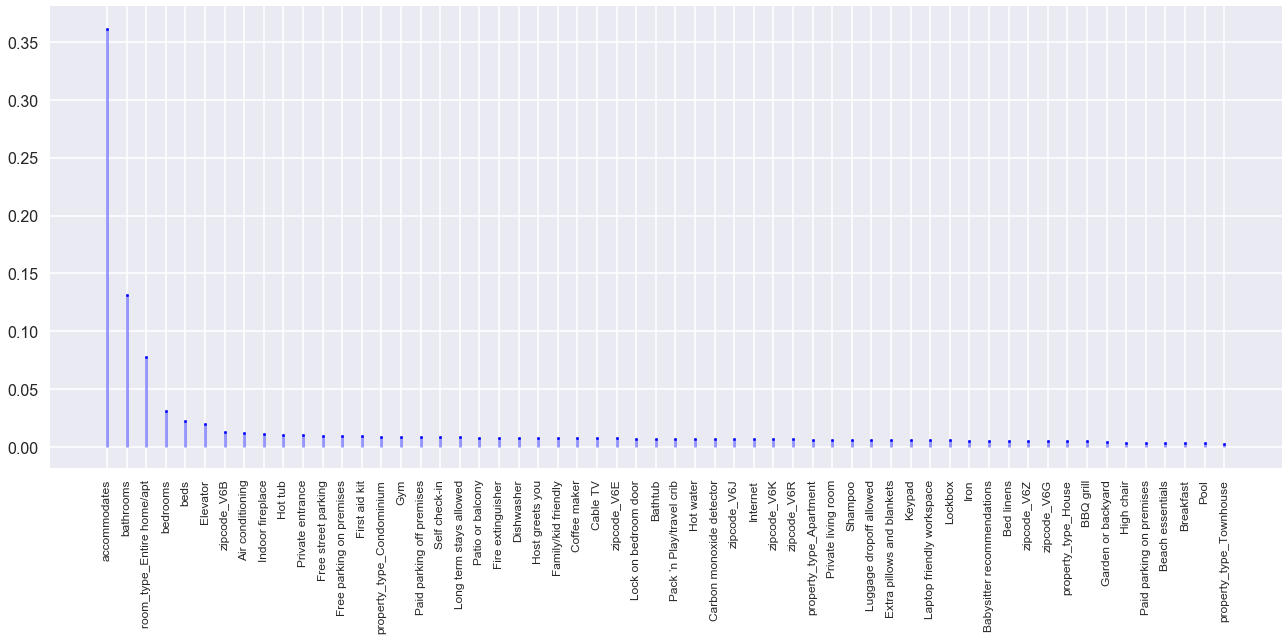

In [164]:
plot_feature_importance(updated_importances_df)

___Answer: Can I predict the prices based on the features of an Airbnb?___



Removing features that cannot be used without prior knowledge appears to have dropped much of the zipcode importance as well. This points towards overfitting of the data prior to the removal of reviews.

The current accuracy of 69% is reasonable given only knowledge of the property and location. This would be enough to guide a new property owner towards establishing a price.

To confirm and visualize this, we will run a scatter of predicted vs actual prices.

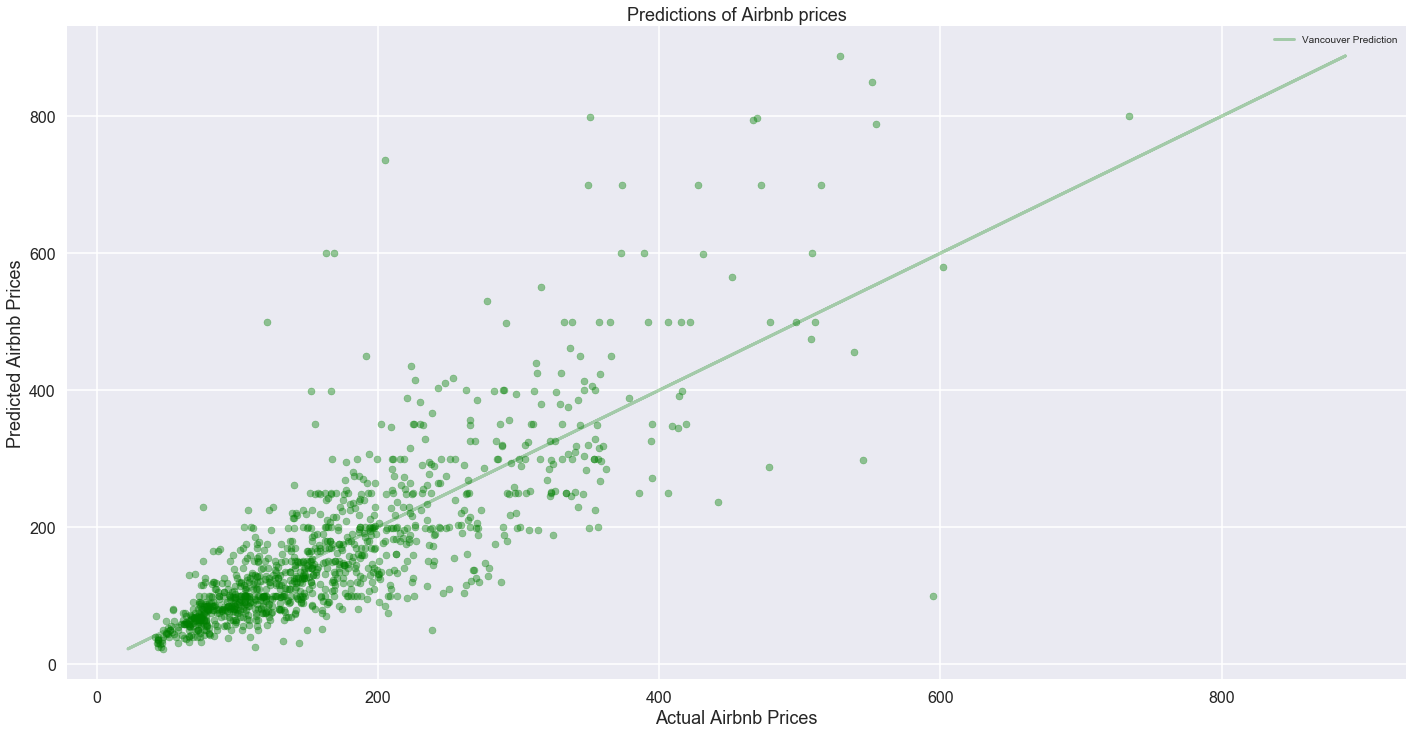

In [171]:
# create plot
fig, ax = plt.subplots(figsize=(24,12))

# Sets up the title based on the plotting column and the market    
ax.set_title(f"Predictions of Airbnb prices", fontsize=18)

plt.scatter(y_pred, y_test, s=50, color='green', alpha=.4)
plt.plot(y_test, y_test, label=f'Vancouver Prediction', color='green', linewidth=3, alpha=.3)

# adds x and y labels
ax.set_ylabel('Predicted Airbnb Prices', fontsize=18)
ax.set_xlabel('Actual Airbnb Prices', fontsize=18)

# plot legend
ax.legend(fontsize=10)

# show/close
plt.show()